In [ ]:
# STEP 1: Upload files from local system
from google.colab import files
uploaded = files.upload()


Saving jokes_post_features_tfidf_256.csv to jokes_post_features_tfidf_256.csv
Saving fitness_post_features_tfidf_256.csv to fitness_post_features_tfidf_256.csv
Saving anxiety_post_features_tfidf_256.csv to anxiety_post_features_tfidf_256.csv
Saving depression_post_features_tfidf_256.csv to depression_post_features_tfidf_256.csv


In [ ]:
# STEP 2: Import libraries
import pandas as pd

# STEP 3: Load datasets
depression_df = pd.read_csv("depression_post_features_tfidf_256.csv")
anxiety_df = pd.read_csv("anxiety_post_features_tfidf_256.csv")
fitness_df = pd.read_csv("fitness_post_features_tfidf_256.csv")
jokes_df = pd.read_csv("jokes_post_features_tfidf_256.csv")


In [ ]:
# STEP 4: Assign binary labels
depression_df['label'] = 1
anxiety_df['label'] = 1
fitness_df['label'] = 0
jokes_df['label'] = 0


In [ ]:
# STEP 5: Combine all four datasets
combined_df = pd.concat([depression_df, anxiety_df, fitness_df, jokes_df], ignore_index=True)


In [ ]:
# STEP 6: Keep only relevant columns
combined_df = combined_df[['post', 'label']]

# Remove any missing or duplicate entries
combined_df = combined_df.dropna().drop_duplicates()


In [ ]:
# STEP 7: Preview the data and label distribution
print("✅ Data loaded and labeled successfully!\n")
print("Total samples:", combined_df.shape[0])
print("Class distribution:\n", combined_df['label'].value_counts())
combined_df.head()


✅ Data loaded and labeled successfully!

Total samples: 90718
Class distribution:
 label
1    53868
0    36850
Name: count, dtype: int64


,post,label
0,My heart aches but i cant break Recently my re...,1
1,Cheers I’m not sure if this is the right sub t...,1
2,Fuck titles. I’m depressed I feel so fucking w...,1
3,suffering from low energy I'm not exaggerating...,1
4,I can already tell This year is just going to ...,1


# **Step 2: Text Preprocessing and Tokenization for LSTM**

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## **1. Clean the Text**

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)        # remove special characters
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

combined_df['clean_post'] = combined_df['post'].apply(clean_text)


## **2. Train-Test Split**

In [ ]:
X = combined_df['clean_post'].values
y = combined_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **3. Tokenize and Pad Sequences**

In [ ]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 300  # limit input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')




## **Final Check**

In [ ]:
print("✅ Text preprocessing and tokenization done!")
print("Padded training shape:", X_train_pad.shape)
print("Padded test shape:", X_test_pad.shape)


✅ Text preprocessing and tokenization done!
Padded training shape: (72574, 300)
Padded test shape: (18144, 300)


# **Step 3: Build and Train the BiLSTM Model (BASELINE MODEL)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


## **Build the BiLSTM Model**

In [ ]:
vocab_size = 20000  # based on tokenizer
embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=300),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## **Compile the Model**

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**


In [ ]:
history = model.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_test_pad, y_test))


Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9009 - loss: 0.2217 - val_accuracy: 0.9712 - val_loss: 0.0806
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9825 - loss: 0.0529 - val_accuracy: 0.9771 - val_loss: 0.0704
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9883 - loss: 0.0391 - val_accuracy: 0.9756 - val_loss: 0.0797
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9925 - loss: 0.0254 - val_accuracy: 0.9753 - val_loss: 0.0870
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9923 - loss: 0.0250 - val_accuracy: 0.9727 - val_loss: 0.0993


## **Evaluate Model Performance for BiLSTM Model Baseline**

### **Confusion Matrix and Classification Report**

567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


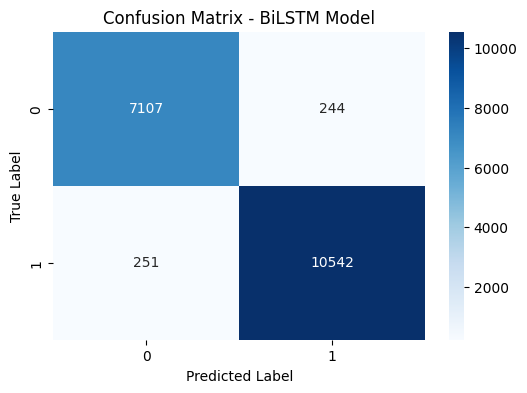

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7351
           1       0.98      0.98      0.98     10793

    accuracy                           0.97     18144
   macro avg       0.97      0.97      0.97     18144
weighted avg       0.97      0.97      0.97     18144



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted probabilities and convert them to binary labels
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BiLSTM Model")
plt.show()

# Print the classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))


### **F1 Score & ROC-AUC Score for BiLSTM Model:**

567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
F1 Score for Baseline BiLSTM Model: 0.9771
ROC-AUC Score for Baseline BiLSTM Model: 0.9957


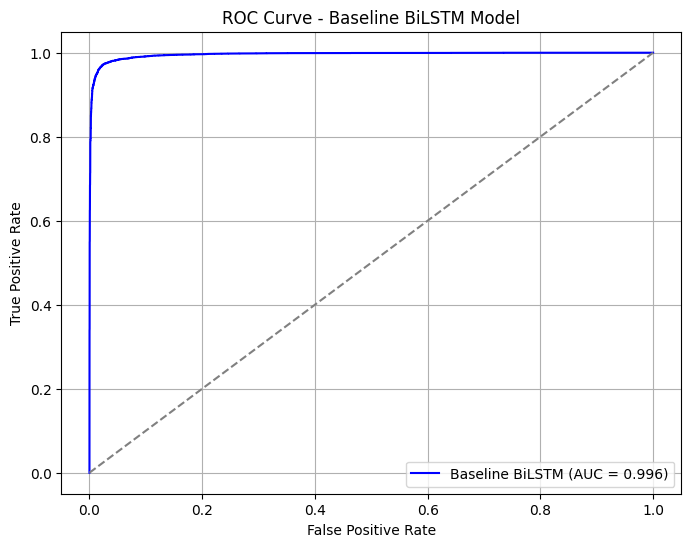

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Obtain prediction probabilities from the BiLSTM model
y_pred_probs = model.predict(X_test_pad).ravel()  # Flatten to shape (n_samples,)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for Baseline BiLSTM Model: {f1:.4f}")

# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score for Baseline BiLSTM Model: {roc_auc:.4f}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Baseline BiLSTM (AUC = {roc_auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line
plt.title('ROC Curve - Baseline BiLSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



### **Accuracy for BiLSTM Model:**

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")


567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9715 - loss: 0.1037

✅ Test Accuracy: 0.9727


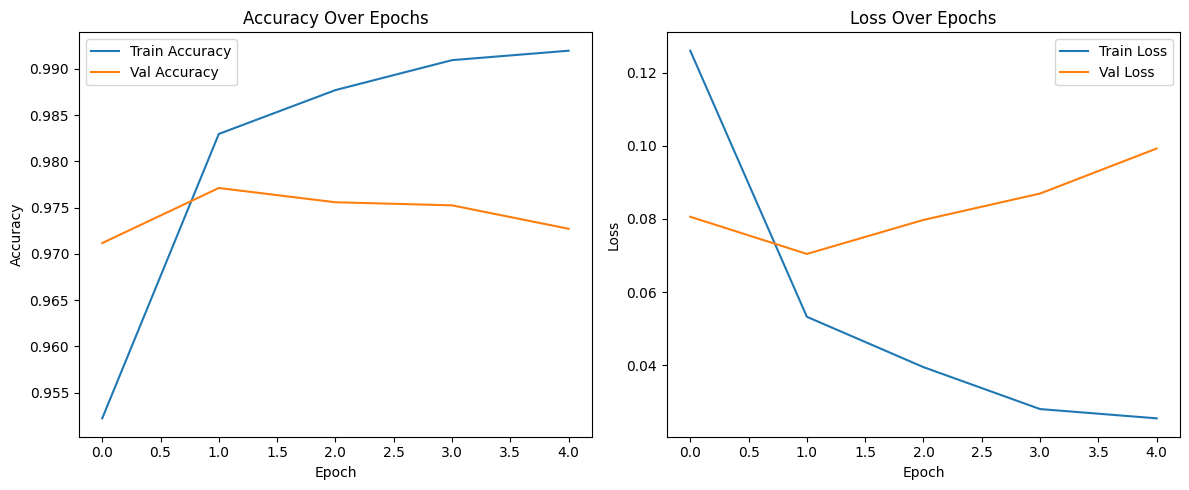

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **Hyper‑parameter Tuning for the BiLSTM Baseline**

In [ ]:
# ---------------------------------------------------------------------------
# Quick‑tune BiLSTM in ≤ 20 minutes
# ---------------------------------------------------------------------------
!pip install -q -U keras-tuner            # install once per runtime

import keras_tuner as kt
from tensorflow.keras import layers, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# ---------------------------------------------------------------------------
# (Optional) use a 30 % random subset for tuning ----------------------------
# Comment‑out the next four lines if you want to tune on the full set.
# ---------------------------------------------------------------------------
# np.random.seed(42)
# idx        = np.random.choice(len(X_train_pad), int(0.30 * len(X_train_pad)), replace=False)
# X_tune_pad = X_train_pad[idx]
# y_tune     = y_train[idx]
# Otherwise keep full data:
X_tune_pad, y_tune = X_train_pad, y_train

# ---------------------------------------------------------------------------
# Model‑building function  (3 tunable knobs)
# ---------------------------------------------------------------------------
def build_bilstm_fast(hp):
    model = Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=hp.Choice("emb_dim", [128, 256]),
            input_length=300),
        layers.Bidirectional(
            layers.LSTM(hp.Choice("lstm_units", [64, 128]))),
        layers.Dropout(0.3),                 # fixed to save search space
        layers.Dense(32, activation="relu"), # fixed
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-3, 5e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"])
    return model

# ---------------------------------------------------------------------------
# Keras‑Tuner RandomSearch  (3 trials × ≤ 4 epochs)
# ---------------------------------------------------------------------------
tuner = kt.RandomSearch(
    hypermodel=build_bilstm_fast,
    objective="val_accuracy",
    max_trials=3,                # **only three combinations**
    directory="tuner_logs",
    project_name="bilstm_ultraquick",
    overwrite=True)

early_stop = EarlyStopping(patience=1, restore_best_weights=True)

tuner.search(
    X_tune_pad, y_tune,
    validation_split=0.20,
    epochs=4,                    # hard cap per trial
    batch_size=64,               # fixed
    callbacks=[early_stop])

# ---------------------------------------------------------------------------
# Retrieve best model & hyper‑parameters
# ---------------------------------------------------------------------------
best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\nBest hyper‑parameters:")
for k, v in best_hp.values.items():
    print(f"  {k:12s}: {v}")

test_loss, test_acc = best_model.evaluate(X_test_pad, y_test, batch_size=256)
print(f"\nTest accuracy: {test_acc:.3f}")



Trial 3 Complete [00h 02m 06s]
val_accuracy: 0.9750602841377258

Best val_accuracy So Far: 0.9755425453186035
Total elapsed time: 00h 04m 39s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Best hyper‑parameters:
  emb_dim     : 128
  lstm_units  : 128
  lr          : 0.001
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9756 - loss: 0.0720

Test accuracy: 0.976


In [ ]:
best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("Chosen hyper‑parameters:")
for k, v in best_hp.values.items():
    print(f"  {k:15s}: {v}")

# Final evaluation
test_loss, test_acc = best_model.evaluate(X_test_pad, y_test, batch_size=256)
print(f"Test accuracy: {test_acc:.3f}")

best_model.save("bilstm_tuned_final.h5")


Chosen hyper‑parameters:
  emb_dim        : 128
  lstm_units     : 128
  lr             : 0.001
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9756 - loss: 0.0720


Test accuracy: 0.976


567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


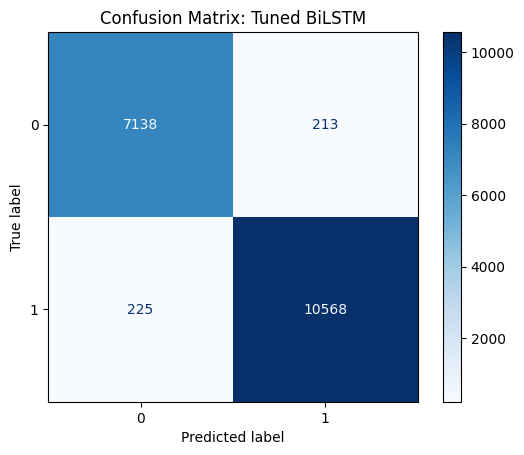

567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


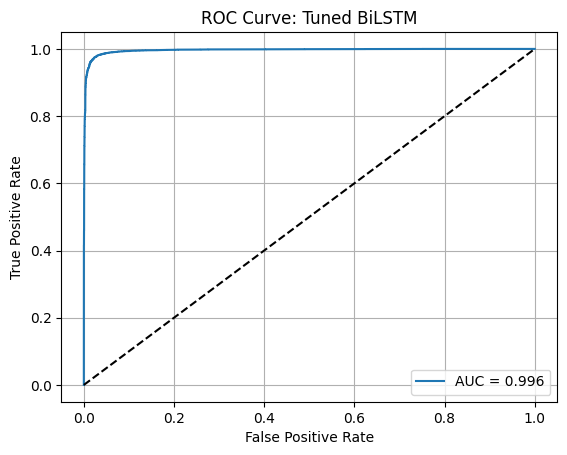

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = (best_model.predict(X_test_pad) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Tuned BiLSTM")
plt.show()

# ROC curve
from sklearn.metrics import roc_curve, auc
y_scores = best_model.predict(X_test_pad).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Tuned BiLSTM")
plt.legend()
plt.grid()
plt.show()


# **Transformer tune Bert Model**

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
# We'll use Adam as a string identifier in compile and then adjust its learning rate.
from tensorflow.keras import backend as K

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# === Step 1: Load the DistilBERT Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# === Step 2: Tokenization ===
max_length = 128
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)

# === Step 3: Create TensorFlow Datasets ===
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

# === Step 4: Load the Pre-trained DistilBERT Model for Sequence Classification ===
model_transformer = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# === Step 5: Compile the Model Using a String Optimizer Identifier ===
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Use "adam" as the optimizer identifier.
model_transformer.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
# Immediately set the learning rate to 5e-5.
K.set_value(model_transformer.optimizer.learning_rate, 5e-5)

# Optionally, force the model to build so that the summary displays correctly.
# model_transformer.build(input_shape=(None, max_length))
# 生成一个正确类型的示例输入
dummy_input = {
    'input_ids': tf.ones((1, max_length), dtype=tf.int32),
    'attention_mask': tf.ones((1, max_length), dtype=tf.int32)
}
# 用示例输入调用模型以初始化参数
_ = model_transformer(dummy_input, training=False)
model_transformer.summary()

# === Step 6: Prepare the Datasets for Training ===
batch_size = 16
train_dataset_shuffled = train_dataset.shuffle(1000).batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# === Step 7: Fine-tune the Transformer Model ===
history_transformer = model_transformer.fit(
    train_dataset_shuffled,
    epochs=3,  # Adjust epochs as desired
    validation_data=test_dataset_batched
)

# === Step 8: Evaluate the Transformer Model ===
loss_val, accuracy_val = model_transformer.evaluate(test_dataset_batched)
print(f"\n✅ Transformer Test Accuracy: {accuracy_val:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
4536/4536 [=========================

## **Confusion Matrices and ROC Curve for transformer BERT tuned**

1134/1134 [==============================] - 84s 73ms/step


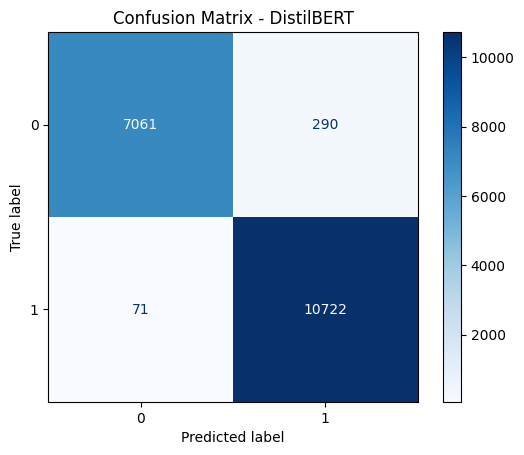

Classification Report:

              precision    recall  f1-score   support

           0     0.9900    0.9605    0.9751      7351
           1     0.9737    0.9934    0.9834     10793

    accuracy                         0.9801     18144
   macro avg     0.9819    0.9770    0.9793     18144
weighted avg     0.9803    0.9801    0.9801     18144



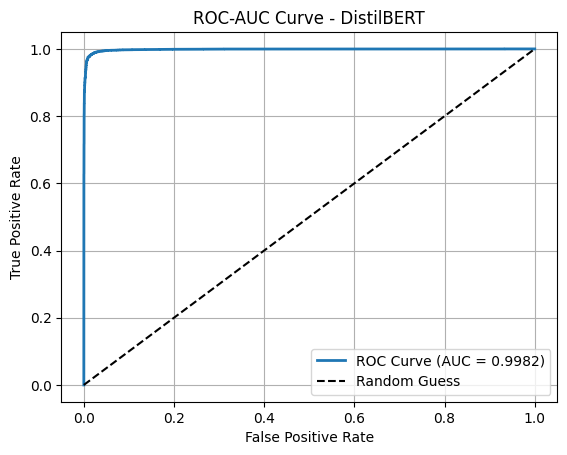

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve

# Step 1: Get model predictions on the batched test dataset
# Get the raw prediction logits
predictions = model_transformer.predict(test_dataset_batched).logits

# Convert logits to probabilities using softmax
y_probs = tf.nn.softmax(predictions, axis=1).numpy()

# Convert probabilities to predicted class labels (0 or 1)
y_preds = np.argmax(y_probs, axis=1)

# Extract the true labels from the test dataset
# Since test_dataset_batched is a tf.data.Dataset, we need to extract all labels
y_true = np.concatenate([label.numpy() for (_, label) in test_dataset_batched], axis=0)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - DistilBERT")
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_preds, digits=4))

# Step 4: ROC-AUC Curve
# Use the probability of the positive class (index 1)
y_prob_positive = y_probs[:, 1]

# Calculate the false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, _ = roc_curve(y_true, y_prob_positive)
auc_score = roc_auc_score(y_true, y_prob_positive)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - DistilBERT")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



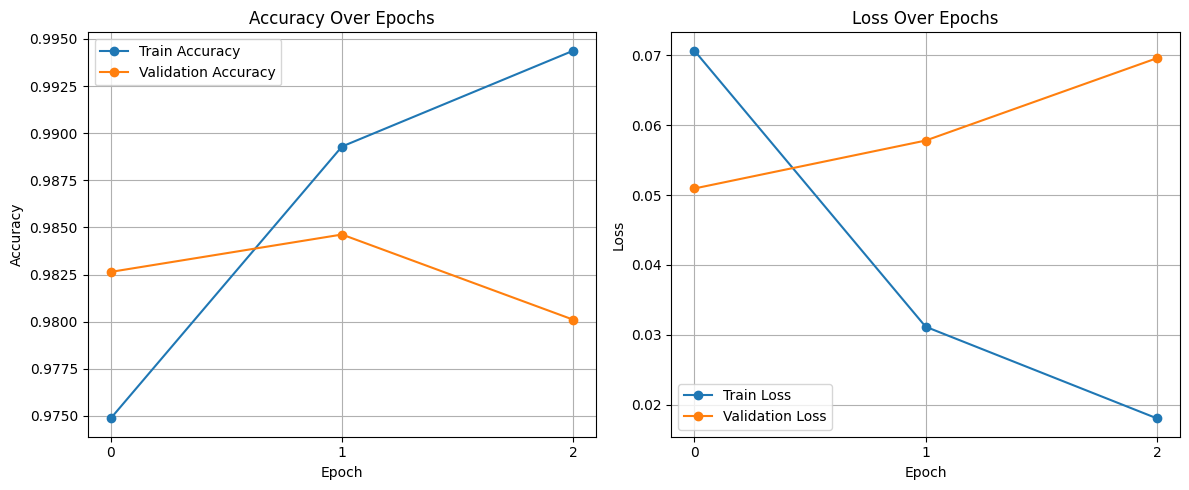

In [ ]:
import matplotlib.pyplot as plt

# Ensure that history_transformer exists (from model.fit)
history = history_transformer.history

# Create a figure with two subplots: one for accuracy and one for loss.
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(history['accuracy'])))  # Assure x-axis ticks per epoch
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], marker='o', label='Train Loss')
plt.plot(history['val_loss'], marker='o', label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(history['loss'])))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **CNN Text Based Model**

In [ ]:
# ✅ Step 6: Build TextCNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

embedding_dim = 128

model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_cnn.summary()

# ✅ Step 7: Train the model
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test_pad, y_test)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8584 - loss: 0.3006 - val_accuracy: 0.9734 - val_loss: 0.0759
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9751 - loss: 0.0735 - val_accuracy: 0.9743 - val_loss: 0.0744
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9859 - loss: 0.0446 - val_accuracy: 0.9735 - val_loss: 0.0858
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9906 - loss: 0.0293 - val_accuracy: 0.9733 - val_loss: 0.0968
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9715 - val_loss: 0.0965


In [ ]:
# ✅ Step 9: Evaluate model performance
loss, acc = model_cnn.evaluate(X_test_pad, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9703 - loss: 0.1017

✅ Test Accuracy: 0.9715


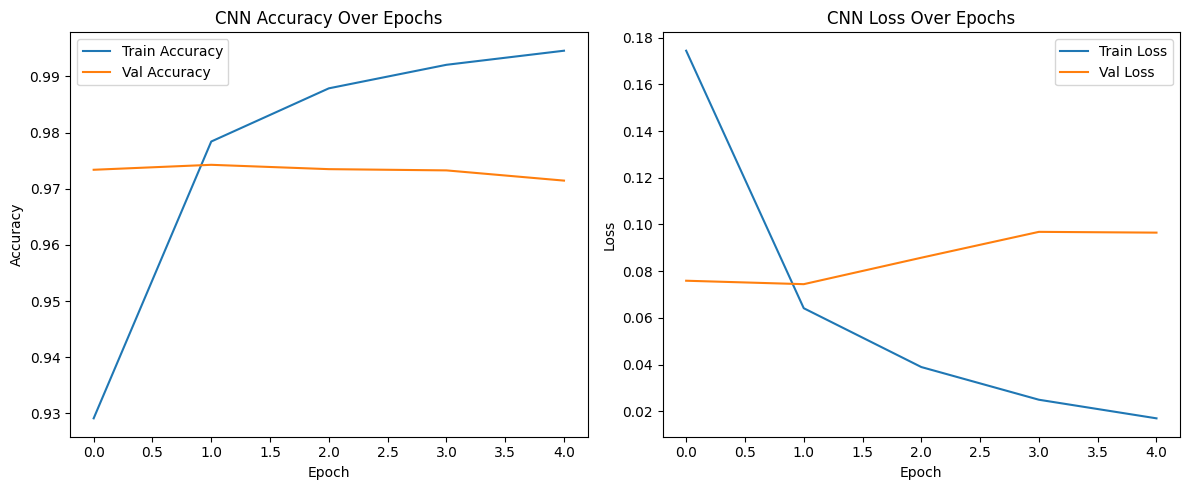

In [ ]:
# ✅ Step 8: Plot training performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **Confusion Matrices and ROC Curve for CNN Model**

567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9703 - loss: 0.1017

 Test Accuracy: 0.9715
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


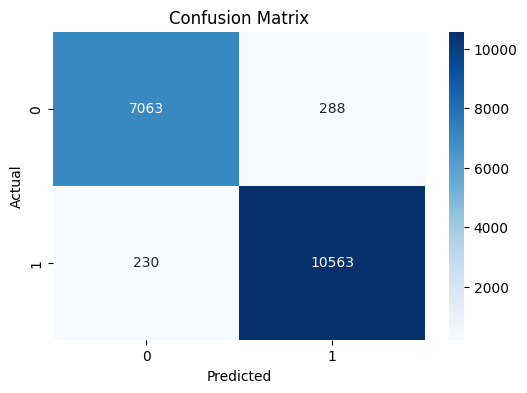

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7351
           1       0.97      0.98      0.98     10793

    accuracy                           0.97     18144
   macro avg       0.97      0.97      0.97     18144
weighted avg       0.97      0.97      0.97     18144



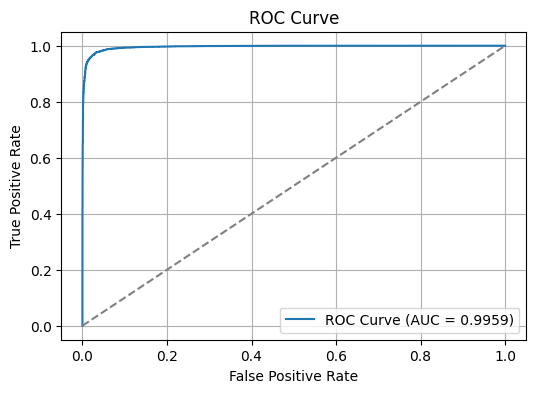

In [ ]:
#  Step 9: Evaluate model performance
loss, acc = model_cnn.evaluate(X_test_pad, y_test)
print(f"\n Test Accuracy: {acc:.4f}")

#  Step 10: Confusion matrix and classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

# Predict probabilities and convert to labels
y_pred_probs = model_cnn.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

#  Step 11: ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# **Final Evaluation:**

In [ ]:
# Evaluate test accuracy for each model:

# 1. Baseline BiLSTM model (using padded sequences)
acc_baseline = model.evaluate(X_test_pad, y_test, batch_size=128, verbose=0)[1]

# 2. Hypertuned BiLSTM model (using padded sequences)
acc_hypertuned = best_model.evaluate(X_test_pad, y_test, batch_size=256, verbose=0)[1]

# 3. Transformer model (evaluation already done on test_dataset_batched)
acc_transformer = accuracy_val  # accuracy_val is obtained from:
#   loss_val, accuracy_val = model_transformer.evaluate(test_dataset_batched)

# 4. CNN model (using padded sequences)
acc_cnn = model_cnn.evaluate(X_test_pad, y_test, batch_size=128, verbose=0)[1]


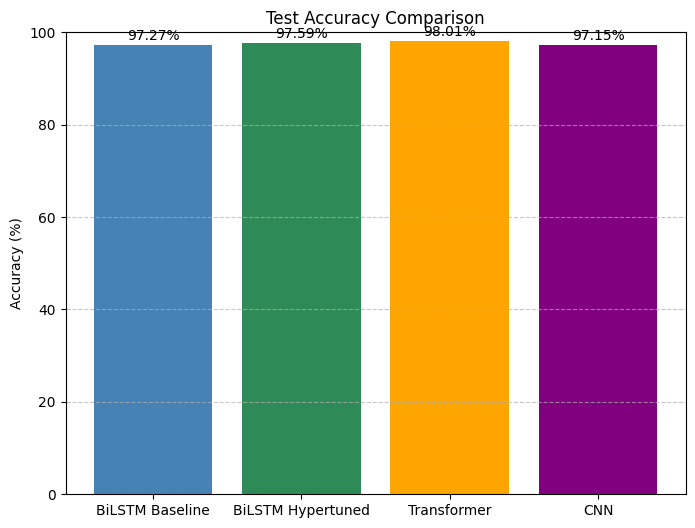

In [ ]:
import matplotlib.pyplot as plt

# List model names and convert accuracy to percentages:
model_names = ["BiLSTM Baseline", "BiLSTM Hypertuned", "Transformer", "CNN"]
accuracies = [acc_baseline, acc_hypertuned, acc_transformer, acc_cnn]
accuracies_pct = [acc * 100 for acc in accuracies]

# Create the bar graph:
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies_pct, color=["steelblue", "seagreen", "orange", "purple"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Comparison")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.2f}%", ha="center", va="bottom")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
import numpy as np

# 1. Baseline BiLSTM model predictions:
pred_baseline = model.predict(X_test_pad, batch_size=128).flatten()  # shape (N,)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, pred_baseline)
auc_baseline = roc_auc_score(y_test, pred_baseline)

# 2. Hypertuned BiLSTM model predictions:
pred_hypertuned = best_model.predict(X_test_pad, batch_size=256).flatten()
fpr_hypertuned, tpr_hypertuned, _ = roc_curve(y_test, pred_hypertuned)
auc_hypertuned = roc_auc_score(y_test, pred_hypertuned)

# 3. Transformer model predictions:
transformer_logits = model_transformer.predict(test_dataset_batched).logits
# Apply softmax and take the probability for the positive class (index 1)
transformer_probs = tf.nn.softmax(transformer_logits, axis=1).numpy()
pred_transformer = transformer_probs[:, 1]
fpr_transformer, tpr_transformer, _ = roc_curve(y_test, pred_transformer)
auc_transformer = roc_auc_score(y_test, pred_transformer)

# 4. CNN model predictions:
pred_cnn = model_cnn.predict(X_test_pad, batch_size=128).flatten()
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, pred_cnn)
auc_cnn = roc_auc_score(y_test, pred_cnn)


142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
1134/1134 [==============================] - 82s 73ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


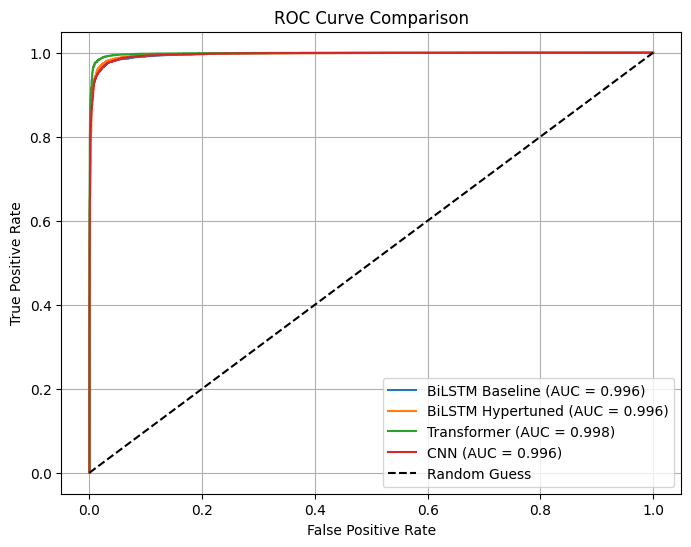

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f"BiLSTM Baseline (AUC = {auc_baseline:.3f})")
plt.plot(fpr_hypertuned, tpr_hypertuned, label=f"BiLSTM Hypertuned (AUC = {auc_hypertuned:.3f})")
plt.plot(fpr_transformer, tpr_transformer, label=f"Transformer (AUC = {auc_transformer:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC = {auc_cnn:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
